# NCP Model
This script will oad the data compilation file (ship.data) and then setup and run the NCP model. Finally, it will produce graphs and plots based on NCP and the cycle/transect/stations.

In [8]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: rworldmap
Error: package or namespace load failed for ‘rworldmap’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘fields’


In [13]:
#setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
# Load the data
load(file='RStates/ship.final.2min.rdata')

## Verify the loaded data
ship.data = ship.data[!is.na(ship.data$LO), ]
ship.data = ship.data[!is.na(ship.data$Cycle), ]
str(ship.data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	38854 obs. of  76 variables:
 $ DT                   : POSIXct, format: "2017-05-31 00:01:00" "2017-05-31 00:03:00" ...
 $ TW                   : num  2.81 2.99 2.41 2.47 3.46 ...
 $ TI                   : num  216 199 216 220 229 ...
 $ TT                   : num  19.4 19.4 19.4 19.4 19.4 ...
 $ SA                   : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS                   : num  5 5 5 5 5 ...
 $ FL                   : num  0.0773 0.075 0.071 0.0707 0.07 ...
 $ AT                   : num  16.7 16.8 16.7 16.7 16.6 ...
 $ BP                   : num  1010 1010 1010 1010 1010 ...
 $ PA                   : num  918 928 928 893 880 ...
 $ SA.1                 : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OX                   : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ OS.1                 : num  5 5 5 5 5 ...
 $ FL.1                 : num  0.0773 0.075 0.071 0.0707 0.07 ...
 $ BT                   : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 

In [16]:
plot.timeseries = function(cycle = 'Cycle1', method = 2) {
    
    if (cycle == 'all') {
        l = 1:nrow(ship.data)
    } else {
        l = which(ship.data$Cycle == cycle)
    }
    
    plot(ship.data$DT[l], rep(0, nrow(ship.data[l,])), col = 'white', ylim=c(1, 12), main=cycle)

    add.normalized.line(ship.data$DT[l], ship.data$EIMS.32[l] / ship.data$EIMS.32.cal[l], offset = 2,
                        scale = 0.3, col='dark green', method = method)
    add.normalized.line(ship.data$DT[l], ship.data$Optode.ch2[l], offset = 10, scale = 0.3, col='blue',
                        method = method)
    add.normalized.line(ship.data$DT[l], ship.data$OX[l], offset = 5, scale = 0.5, method = method)
    add.normalized.line(ship.data$DT[l], ship.data$MIMS.32[l] / ship.data$MIMS.32.cal[l], offset = 8,
                        scale = 0.3, col='dark green', method = method)
    add.normalized.line(ship.data$DT[l], ship.data$EIMS.O2[l], offset = 4, scale = 0.3, col='blue', method = method)

    text(ship.data$DT[l[1]] + 13000, 11, 'Optode Ch2', cex=0.7)
    text(ship.data$DT[l[1]] + 13000, 9, 'MIMS 32', cex=0.7)
    text(ship.data$DT[l[1]] + 13000, 7, 'Ship O2', cex=0.7)
    text(ship.data$DT[l[1]] + 13000, 5, 'EIMS O2', cex=0.7)
    text(ship.data$DT[l[1]] + 13000, 3, 'EIMS 32', cex=0.7)
}

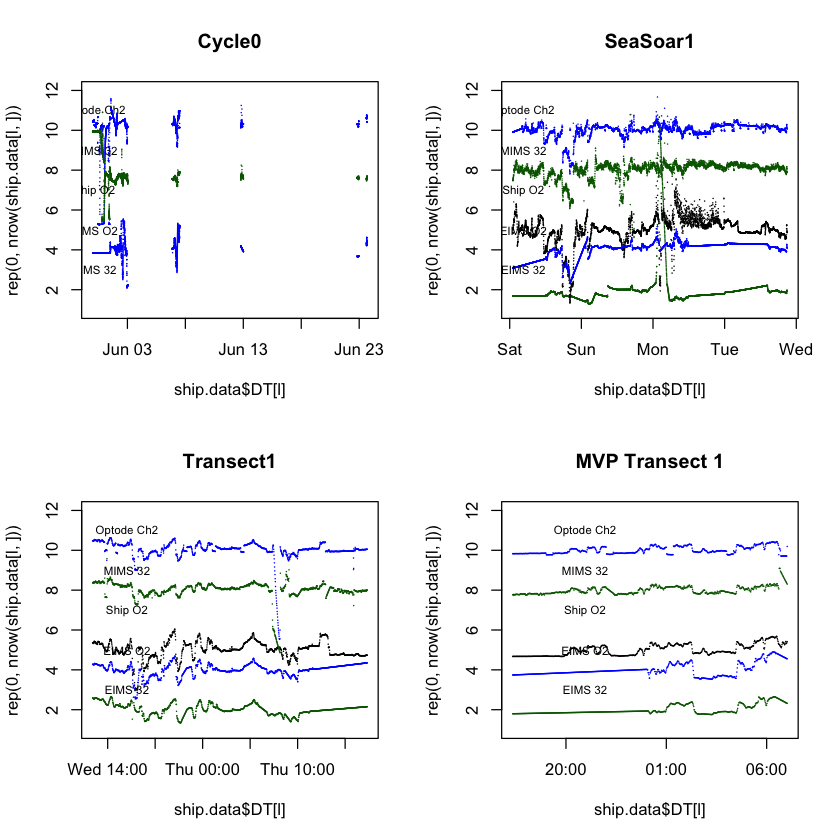

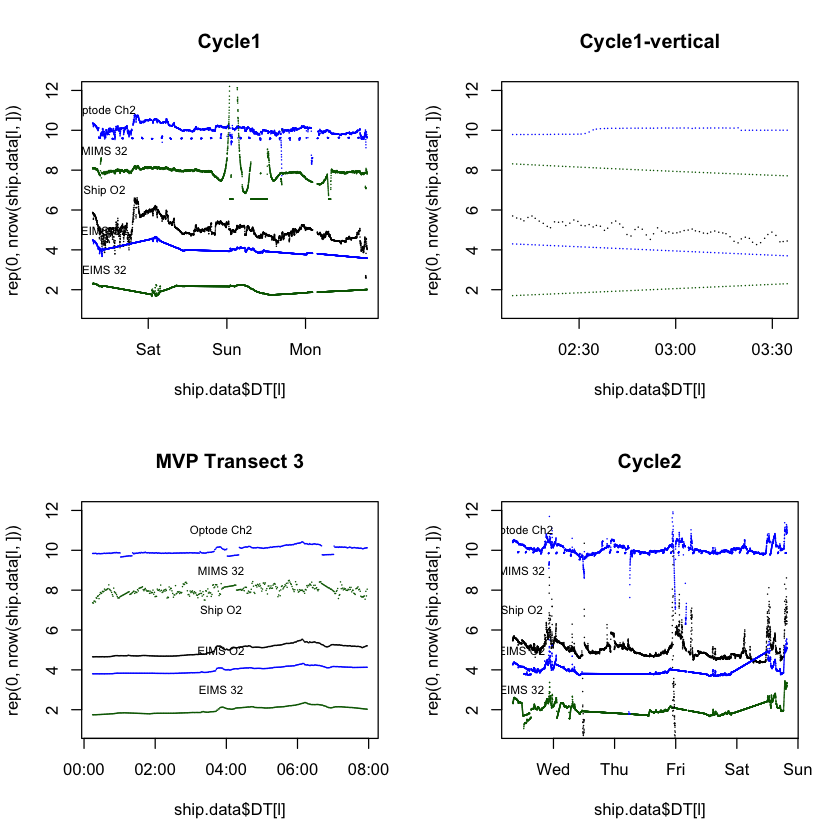

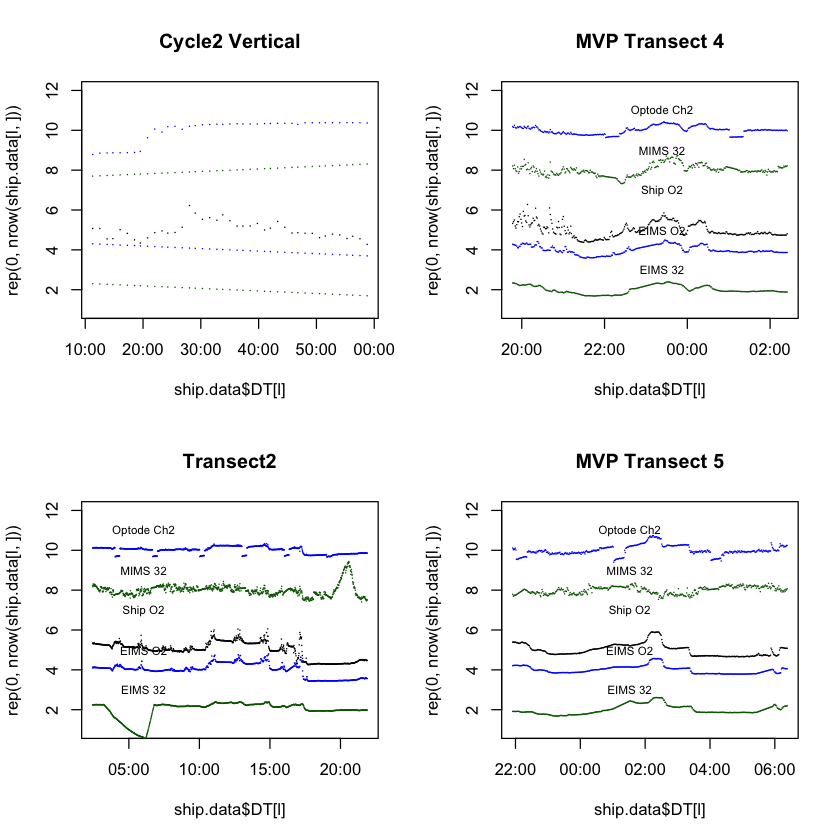

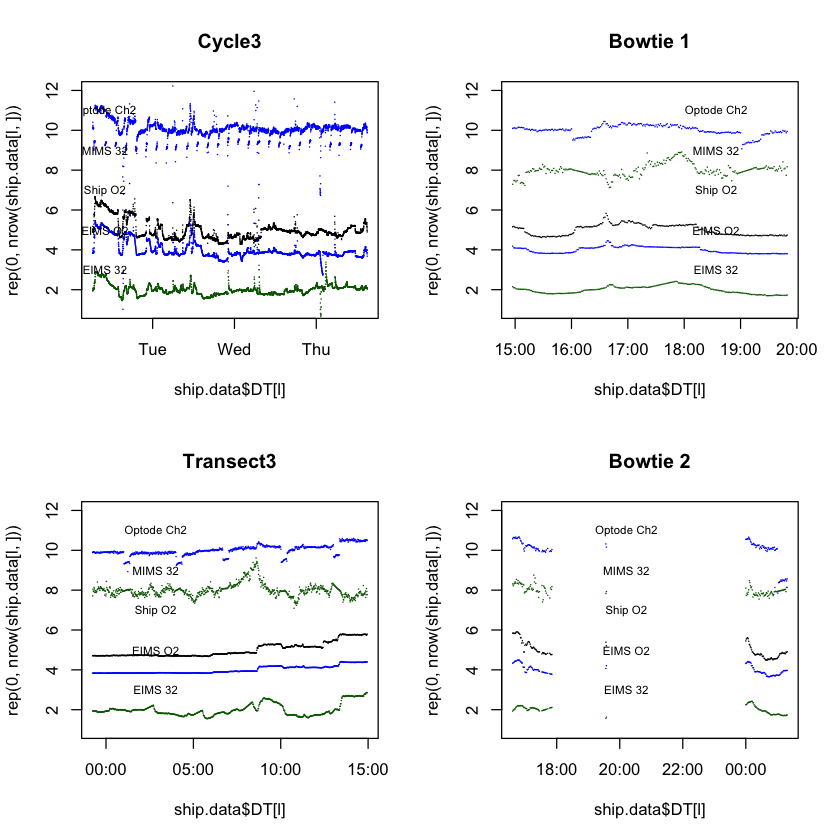

null device 
          1

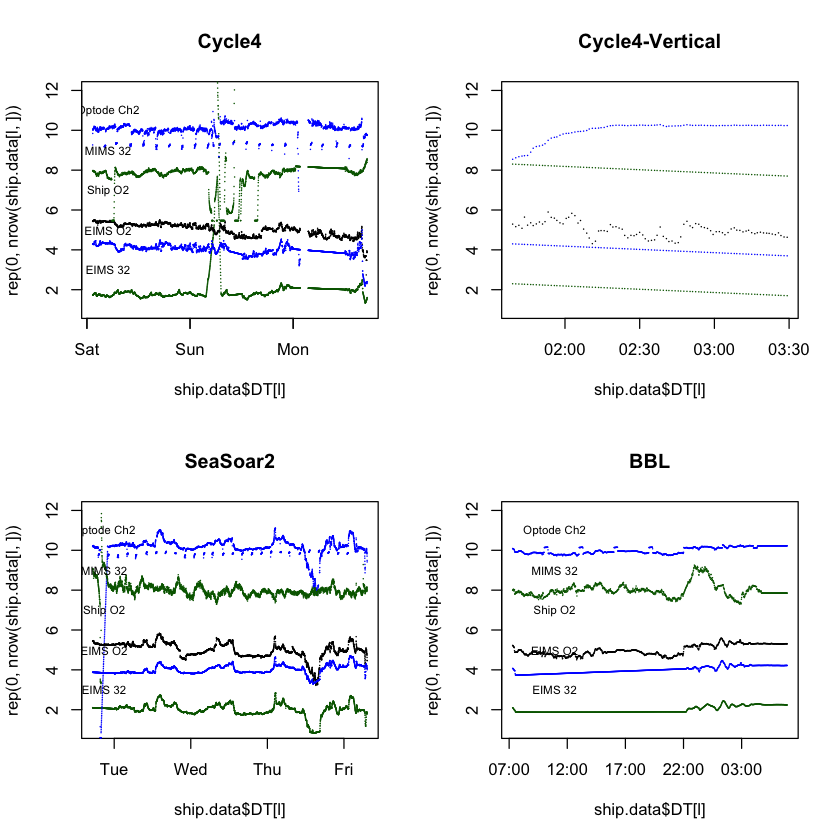

In [20]:
#pdf('Output/NCP Module - Timeseries Review (Individual Oxygen).pdf')
#png('Output/NCP Module - Timeseries Review (Individual Oxygen).png')

par(mfrow=c(2,2))
for (i in unique(ship.data$Cycle)) {
    plot.timeseries(i)
}

dev.off()

In [21]:
## Check value at 35PSU, 10C
#### 274.61

O2sol = function(S=35, T=10) { ## umol Kg-1
    
    # convert T to scaled temperature
    Ts = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A.0 = 5.80871
    A.1 = 3.20291
    A.2 = 4.17887
    A.3 = 5.10006
    A.4 = -9.86643e-2
    A.5 = 3.80369
    
    B.0 = -7.01577e-3
    B.1 = -7.70028e-3
    B.2 = -1.13864e-2
    B.3 = -9.51519e-3
    
    C.0 = -2.75915e-7

    A.calc = A.0 + A.1*Ts + A.2*Ts^2 + A.3*Ts^3 + A.4*Ts^4 + A.5*Ts^5
    B.calc = B.0 + B.1*Ts + B.2*Ts^2 + B.3*Ts^3
    
    ## (umol / kg)
    exp(A.calc + S * B.calc + C.0 * S^2)
}

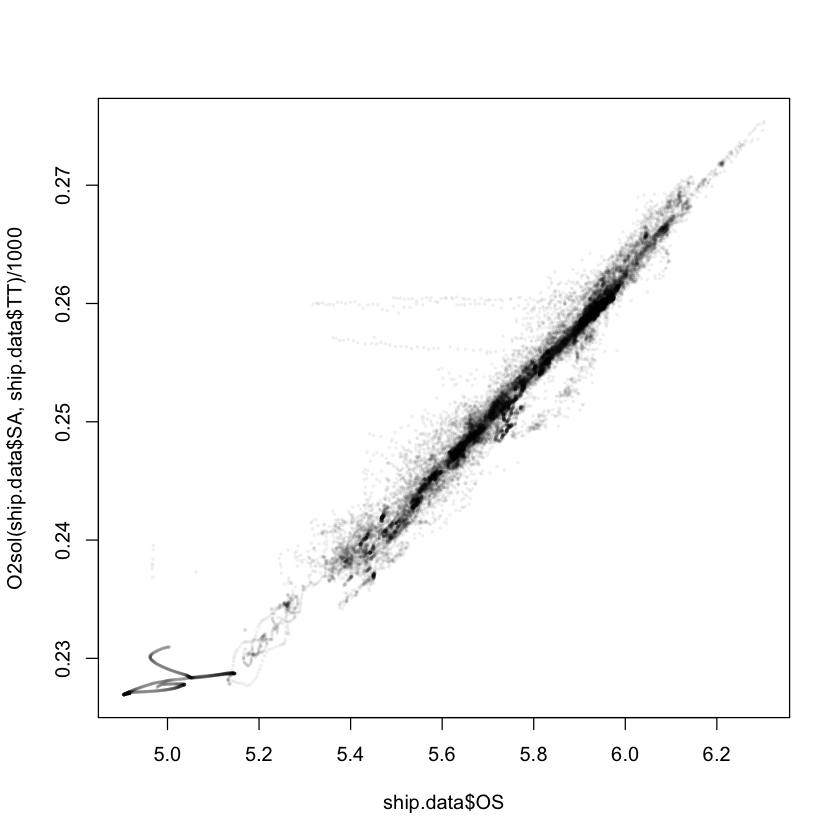

In [22]:
plot(ship.data$OS, O2sol(ship.data$SA, ship.data$TT)/1000, pch=16, cex=0.4, col='#00000010')

In [23]:
#### Calcualtes density from S and T (Massel 2015)
rho = function(S=30, T=15, p=0) {
    a.0 = 999.842594
    a.1 = 6.793953e-2
    a.2 = -9.095290e-3
    a.3 = 1.001685e-4
    a.4 = -1.120083e-6
    a.5 = 6.536332e-9
    rho.smow = a.0 + a.1*T + a.2*T^2 + a.3*T^3 + a.4*T^4 + a.5*T^5
    
    b.0 = 8.2449e-1
    b.1 = -4.0899e-3
    b.2 = 7.6438e-5
    b.3 = -8.2467e-7
    b.4 = 5.3875e-9
    B.1 = b.0 + b.1*T + b.2*T^2 + b.3*T^3 + b.4*T^4
    
    c.0 = -5.7246e-3
    c.1 = 1.0227e-4
    c.2 = -1.6546e-6
    d.0 = 4.8314e-4
    C.1 = c.0 + c.1*T + c.2*T^2
    
    rho = rho.smow + B.1 * S + C.1 * S^1.5 + d.0 * S^2
    rho
}

# NCP Calculation

In [24]:
# NCP in mmol O2 m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;

calc.ncp = function(o2ar, o2ar.cal, S, T, k) {
    ncp = (o2ar / o2ar.cal - 1) * O2sol(S, T) / 1000 * rho(S, T) * k
}

ship.data$NCP.EIMS = calc.ncp(ship.data$EIMS.O2.Ar, ship.data$EIMS.O2.Ar.cal, ship.data$SA, ship.data$TT, ship.data$k)

ship.data$NCP.MIMS = calc.ncp(ship.data$MIMS.O2.Ar, ship.data$MIMS.O2.Ar.cal,
                              ship.data$SA, ship.data$TT, ship.data$k)

ship.data = ship.data[!is.na(ship.data$NCP.EIMS),]
ship.data = ship.data[!is.na(ship.data$NCP.MIMS),]

# Preliminary Review

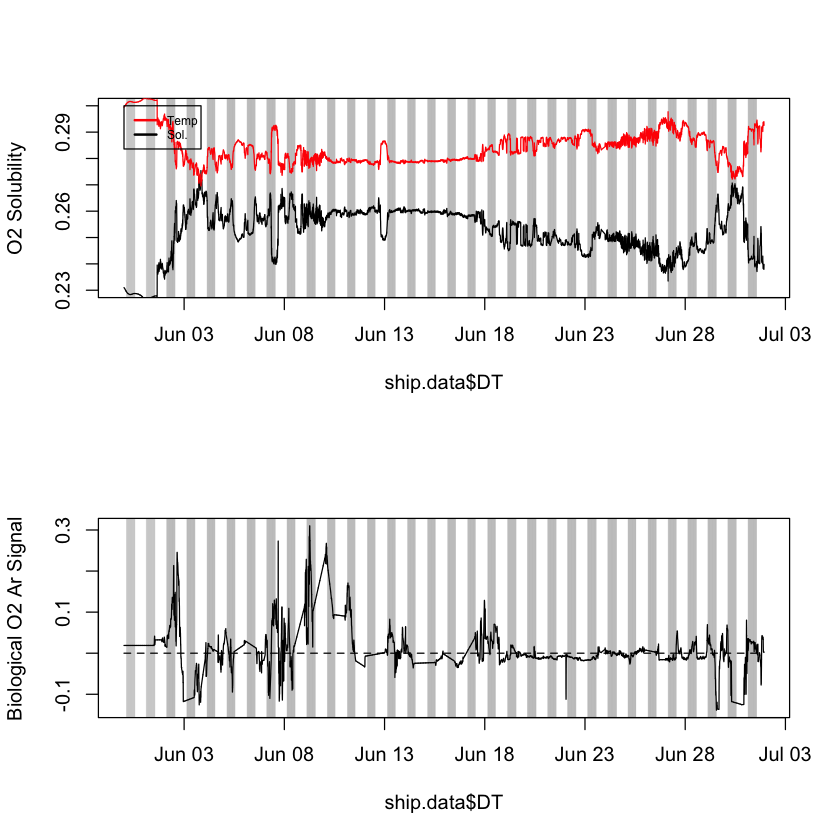

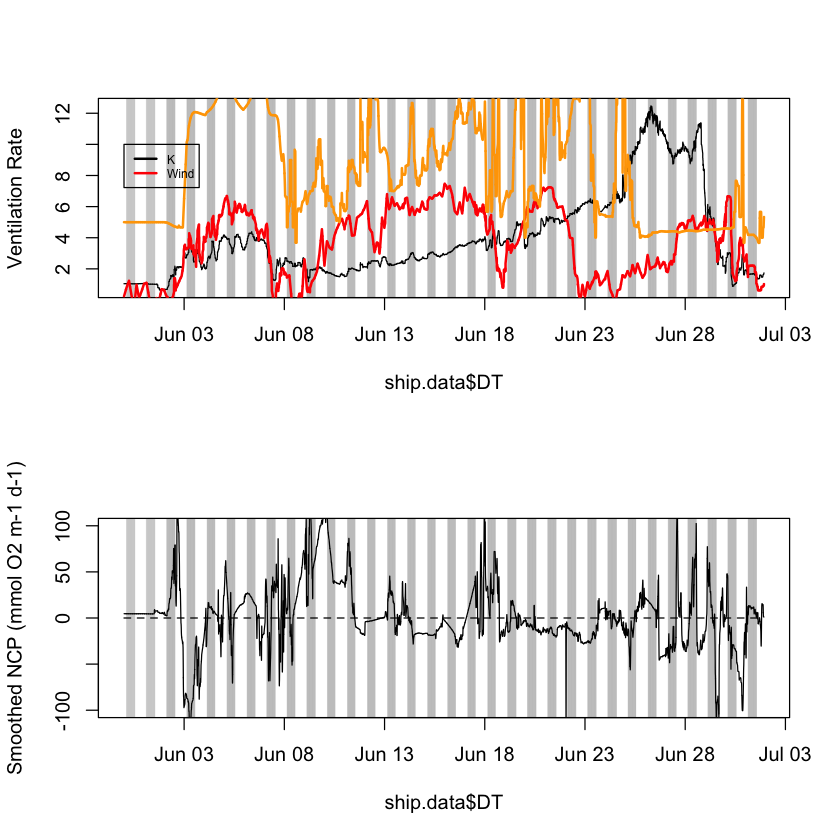

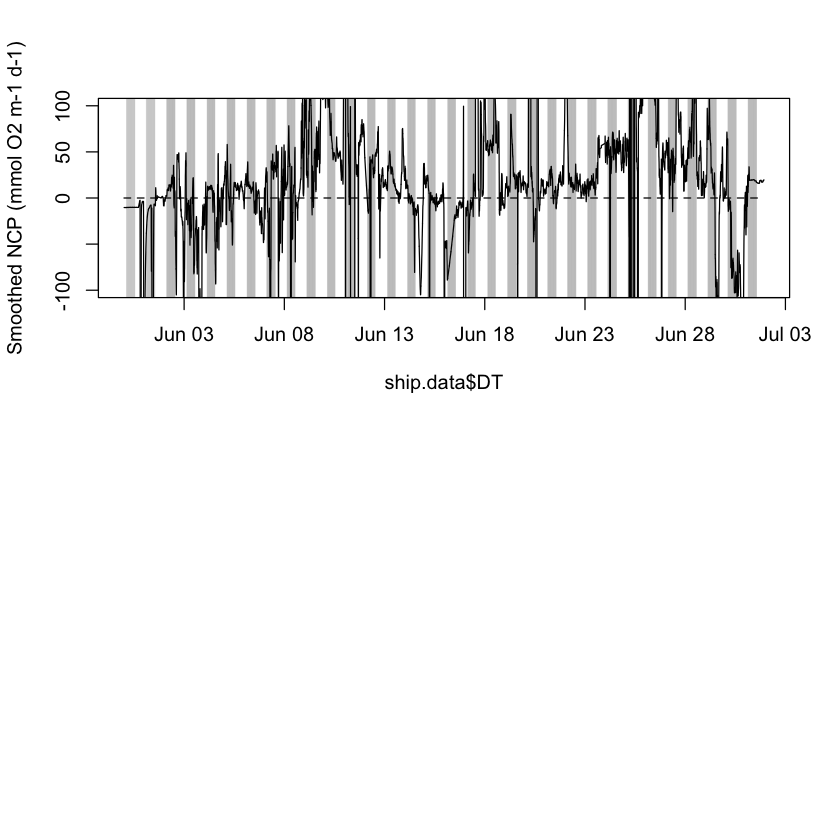

In [25]:
#pdf('Output/NCP Module - NCP Diagnostics.pdf')
#png('Output/NCP Module - NCP Diagnostics.png')

par(mfrow=c(2,1))

## O2 solubility and temperature
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l', ylab='O2 Solubility', ylim=c(0.23, 0.30))
add.daynight()
lines(ship.data$DT, ship.data$TT/300 + 0.235, col='red', lwd=1)
legend(ship.data$DT[1], 0.30, c('Temp', 'Sol.'), col=c('red', 'black'), cex=0.6, lwd=2)

## Biological O2 argon singal
plot(ship.data$DT,  (ship.data$EIMS.O2.Ar / ship.data$EIMS.O2.Ar.cal - 1), type='l', ylab='Biological O2 Ar Signal')
add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

## Wind speed and k values
plot(ship.data$DT, ship.data$k, type='l', ylab='Ventilation Rate')
add.daynight()
lines(ship.data$DT, ship.data$NCEP/2, col='red', lwd=2)
lines(ship.data$DT, ship.data$MLD/3, col='orange', lwd=2)
legend(ship.data$DT[1], 10, c('K', 'Wind'), col=c('black', 'red'), cex=0.6, lwd=2)

## NCP plot (smoothed)
plot(ship.data$DT, ma(ship.data$NCP.EIMS, 15), type='l', ylab='Smoothed NCP (mmol O2 m-1 d-1)', ylim=c(-100, 100))
add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

plot(ship.data$DT, ma(ship.data$NCP.MIMS, 15), type='l', ylab='Smoothed NCP (mmol O2 m-1 d-1)', ylim=c(-100, 100))
add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

## lines(ship.data$DT,  O2sol(ship.data$SA, ship.data$TT) - ship.data$OS) ## TODO: COnvert ship O2 to useable units
#lines(ship.data$DT, (rho(S = ship.data$SA, ship.data$TT)*10 - 10400), col='red', lwd=2)
#legend(ship.data$DT[1], -100, c('NCP', 'Rho'), col=c('black', 'red'), cex=0.6, lwd=2)

## NCP plot (smoothed)
#plot(ship.data$DT, rho(S = ship.data$SA, ship.data$TT), type='l', ylab='Density (Kg m-3)')

#dev.off()

In [26]:
#pdf('Output/NCP Module - Spatial NCP.pdf')
#png('Output/NCP Module - Spatial NCP.png')

#This adds a column of color values
# based on the y values
ncp2 = ship.data$NCP.MIMS
ncp2[ncp2 < -100] = -100
ncp2[ncp2 > 100] = 100

#col <- get.pal(ncp2)
col = make.div.pal(ncp2, 100)

plot.map(ship.data$LO, ship.data$LA, col = col, main='Preliminary NCP Values')

## Legend
points(x = rep(-118, 101), y = seq(34, 36, 1/50), col=get.div.pal(101), pch=16)
text(-117.6, 36, paste0(floor(max(ncp2))))
text(-117.6, 34, paste0(floor(min(ncp2))))

#dev.off()

ERROR: Error in getMap(resolution = "high"): could not find function "getMap"


In [14]:
save(ship.data, file='./RStates/ship.ncp.rdata')
#write.xlsx(ship.data, file='./Input Data/Shipdata - NCP.xlsx')

# Cycles Analysis

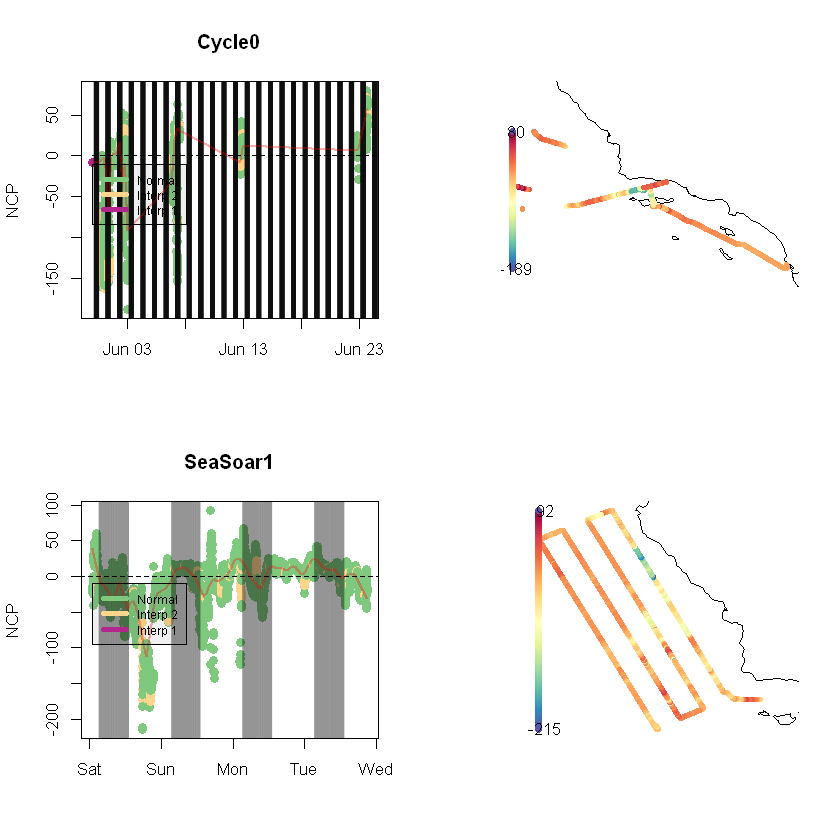

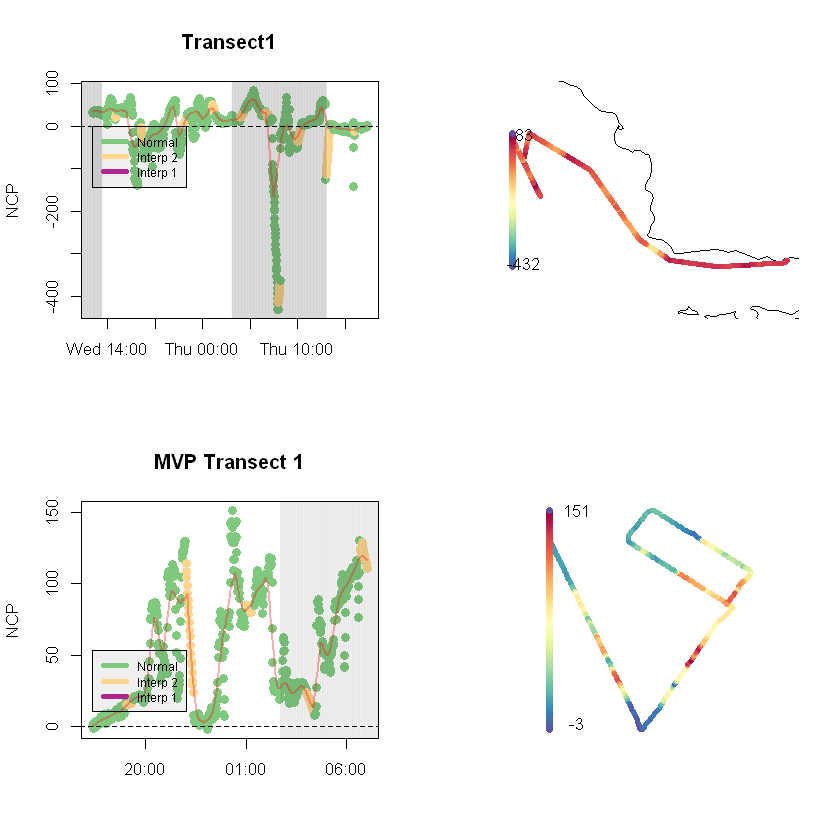

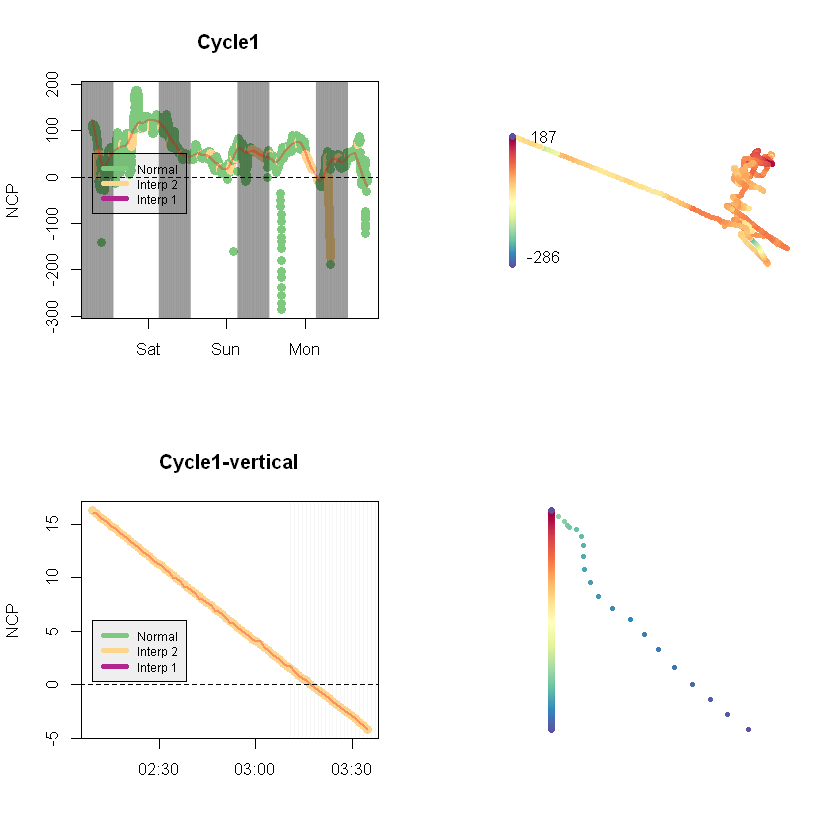

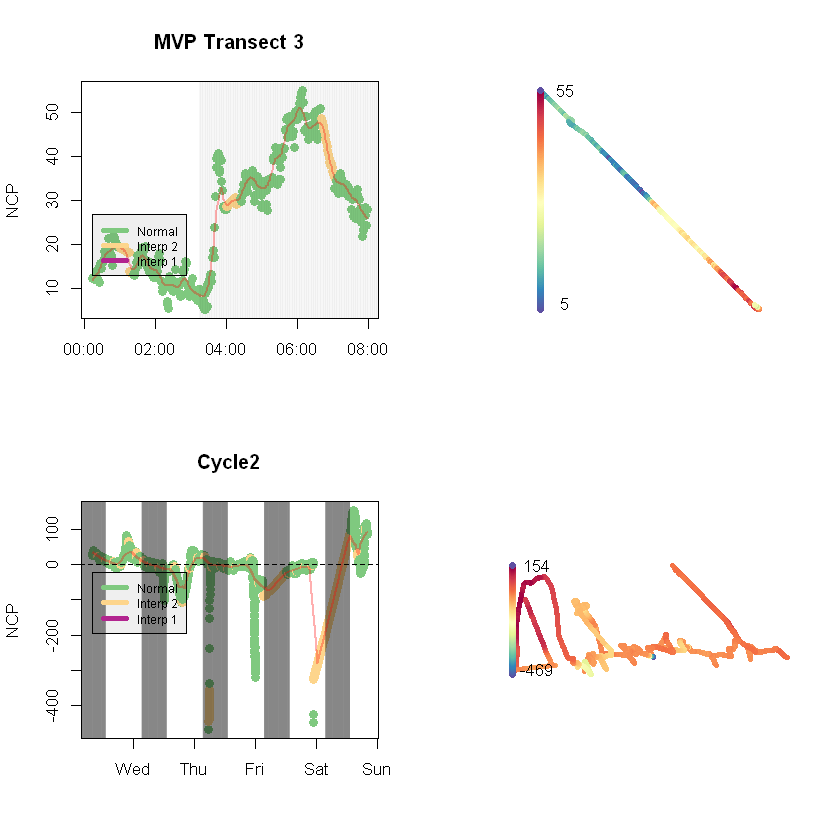

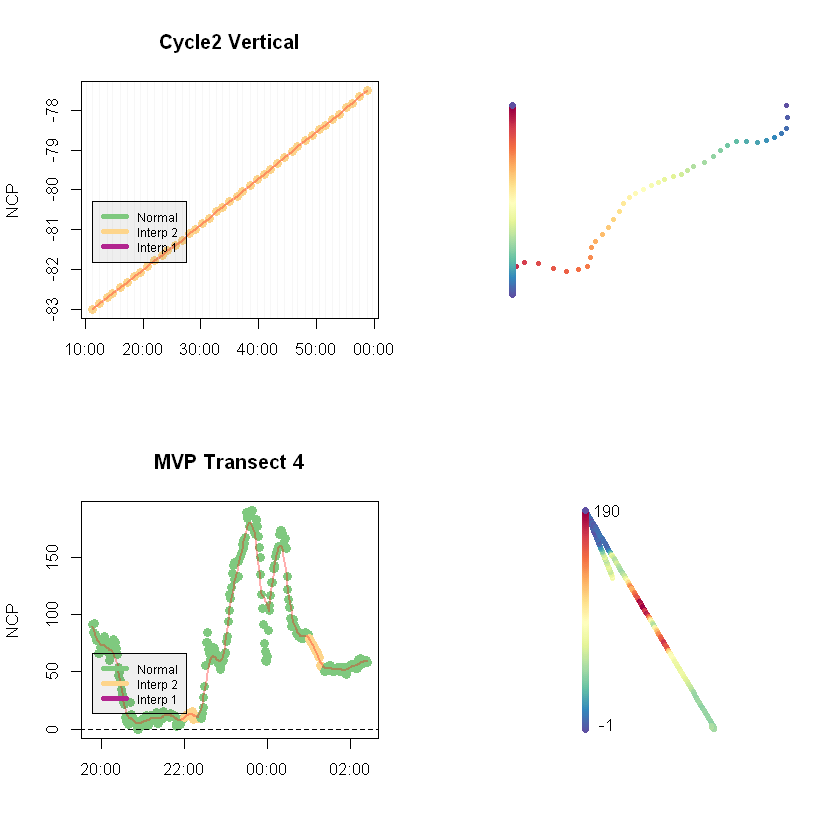

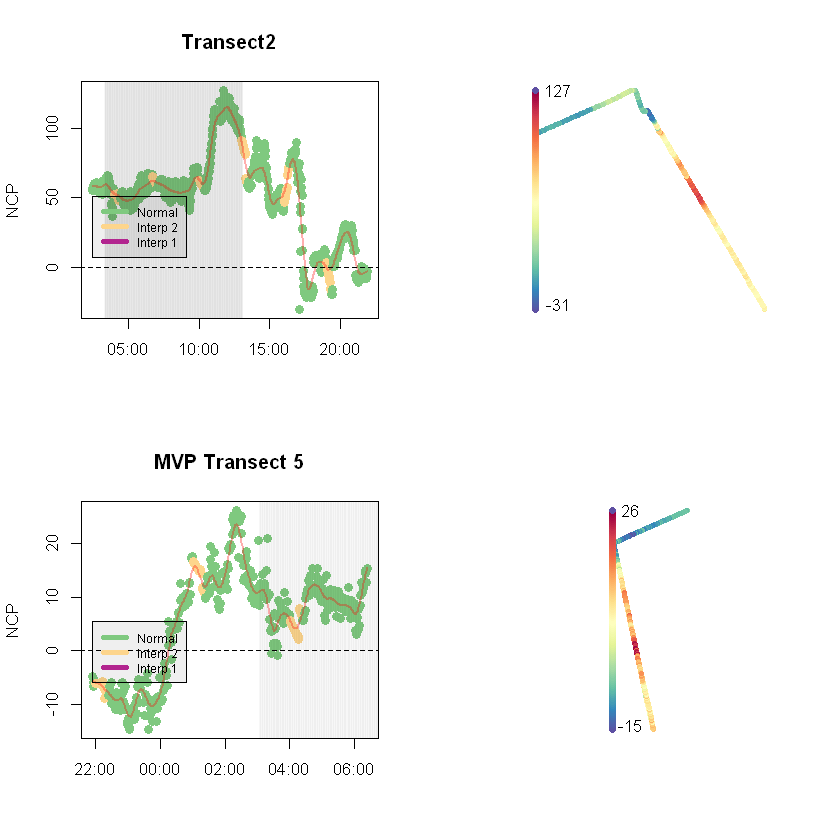

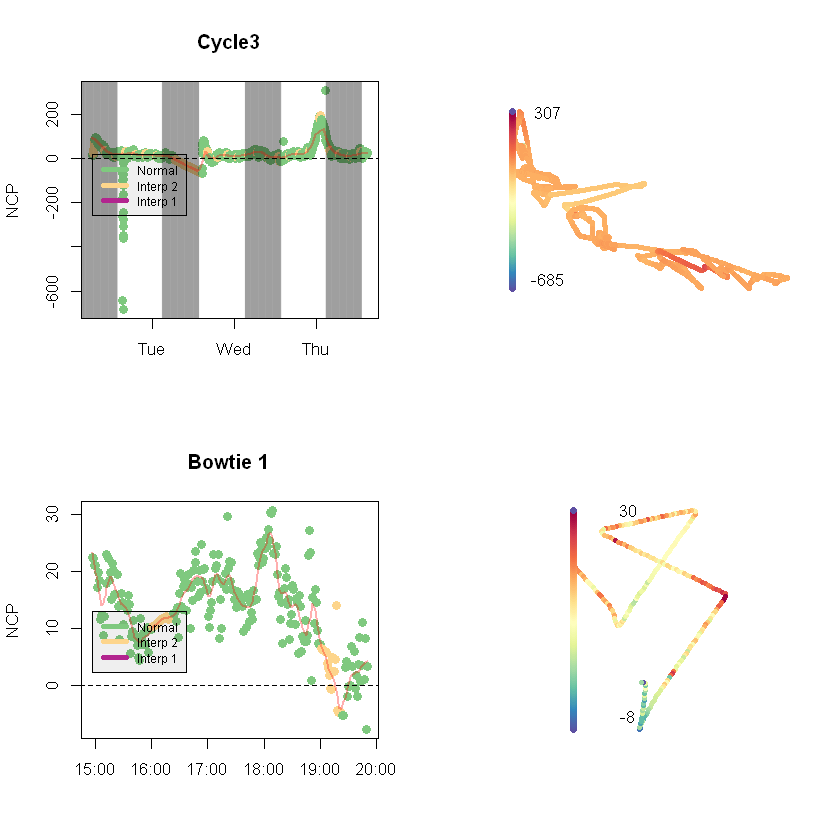

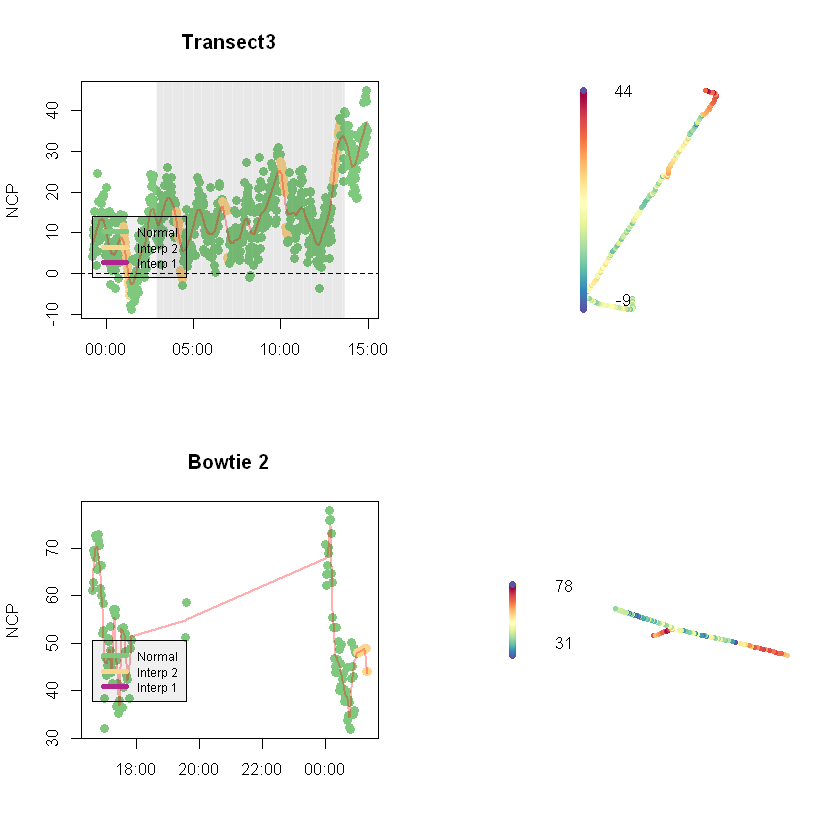

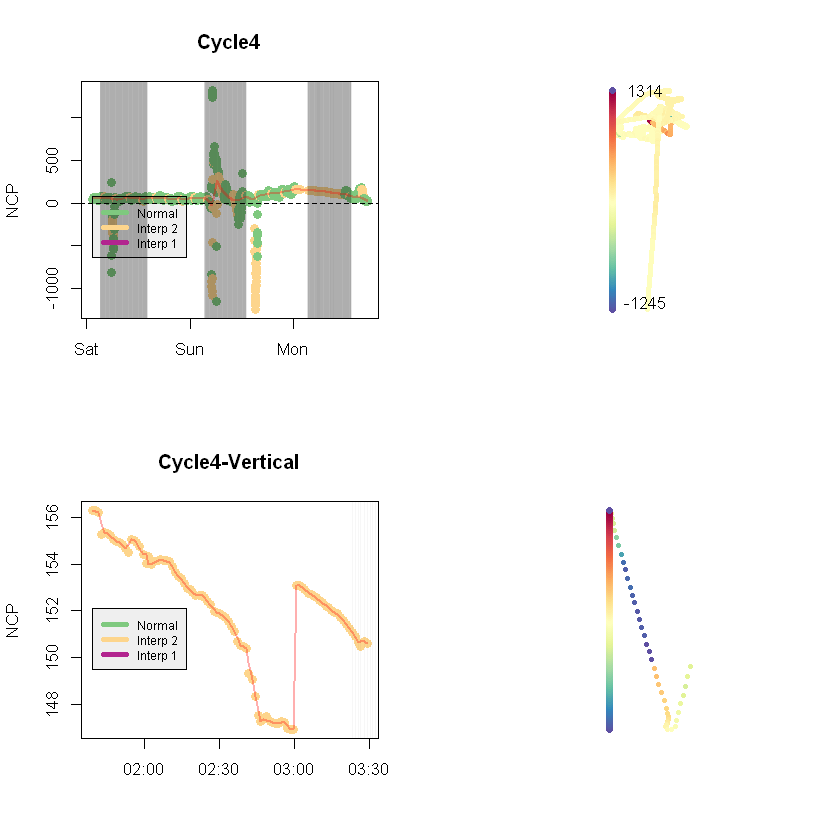

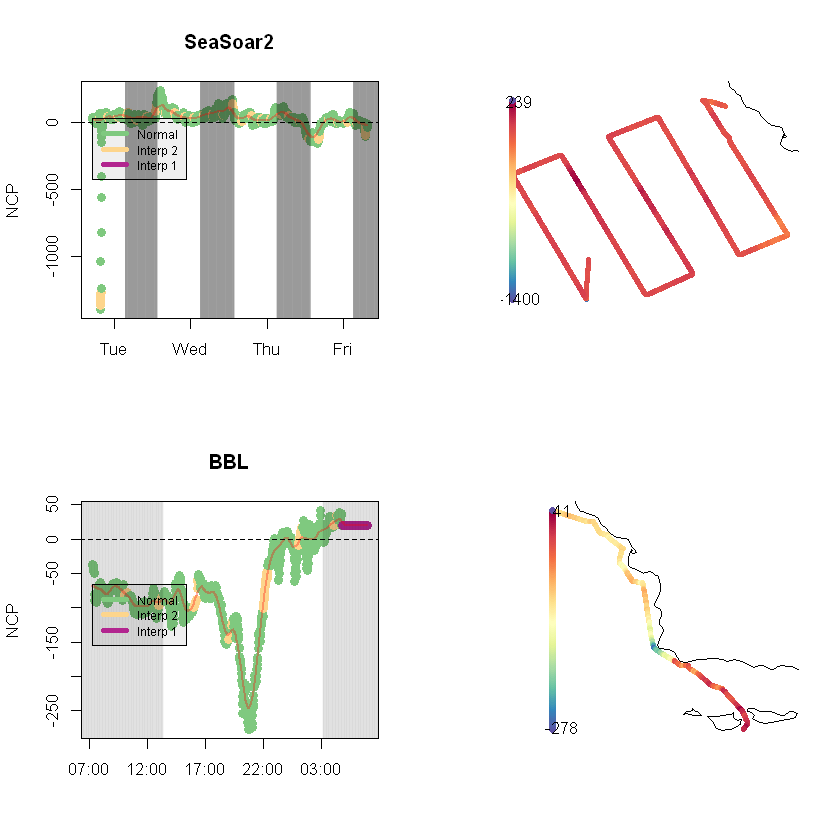

png 
  3

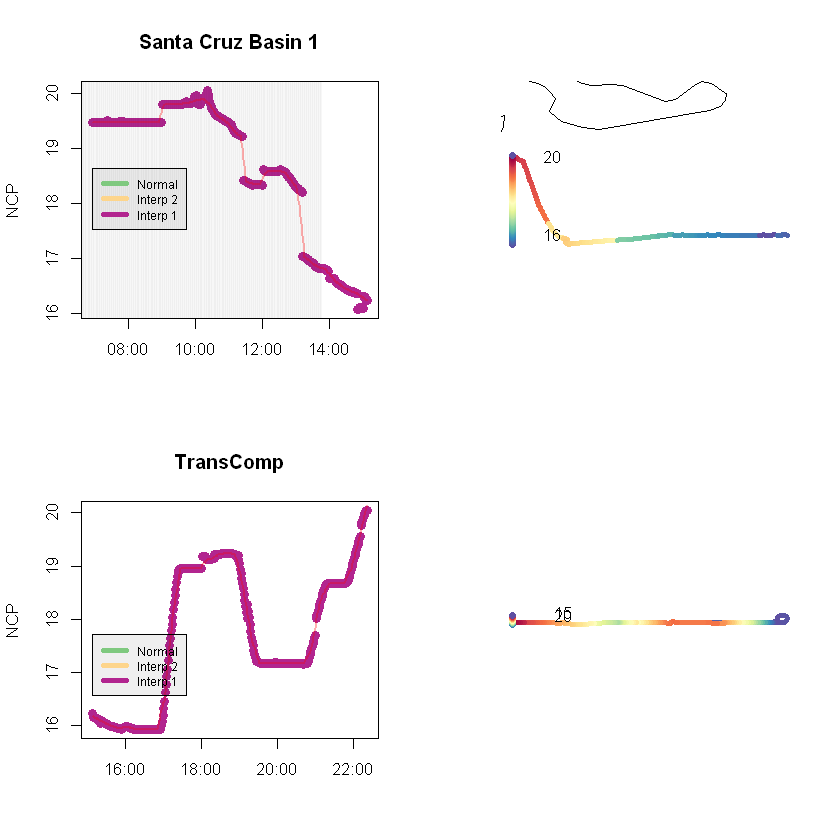

In [22]:
#pdf('Output/NCP Module - NCP Cycles Preliminary.pdf')
#png('Output/NCP Module - NCP Cycles Preliminary.png')

par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    
    ## Set colors
    col = make.div.pal(ship.data$NCP.MIMS[l], 110)
    flag.col = get.qual.pal(n = 4)
    
    ##########################
    ## Plot the Timesseries ##
    ##########################
    plot(ship.data$DT[l], ship.data$NCP.MIMS[l], main=i, pch=16, cex=1.2, lwd=2,
         ylab='NCP', xlab='', col=flag.col[ship.data$MIMS.O2.Ar.FLAG[l]])
    
    add.daynight('#00000008')
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$NCP.MIMS[l], f = 0.05)
    lines(mod, col='#ff000050', lwd=2)
    lines(x=c(min(ship.data$DT), max(ship.data$DT)), y= c(0, 0), lty=2) # Zero line
    legend(ship.data$DT[l[1]], mean(ship.data$NCP.MIMS[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.7, lwd=4, bg='#00000010')
    
    
    #########################
    ## Plot Spatial Extent ##
    #########################
    plot.map(ship.data$LO[l], ship.data$LA[l], col=col)
    points(x = rep(min(ship.data$LO[l]), 101), y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out=101),
           col=get.div.pal(100), pch=16)
    text(min(ship.data$LO[l])+0.08, max(ship.data$LA[l]), floor(max(ship.data$NCP.MIMS[l])))
    text(min(ship.data$LO[l])+0.08, min(ship.data$LA[l])+0.02, floor(min(ship.data$NCP.MIMS[l])))
}

dev.off()

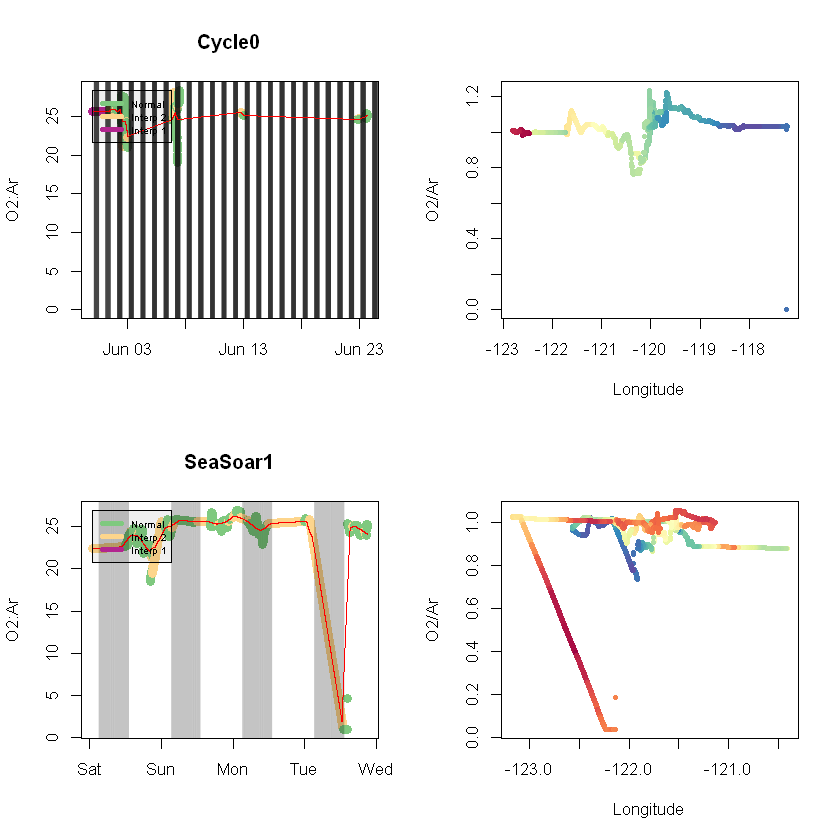

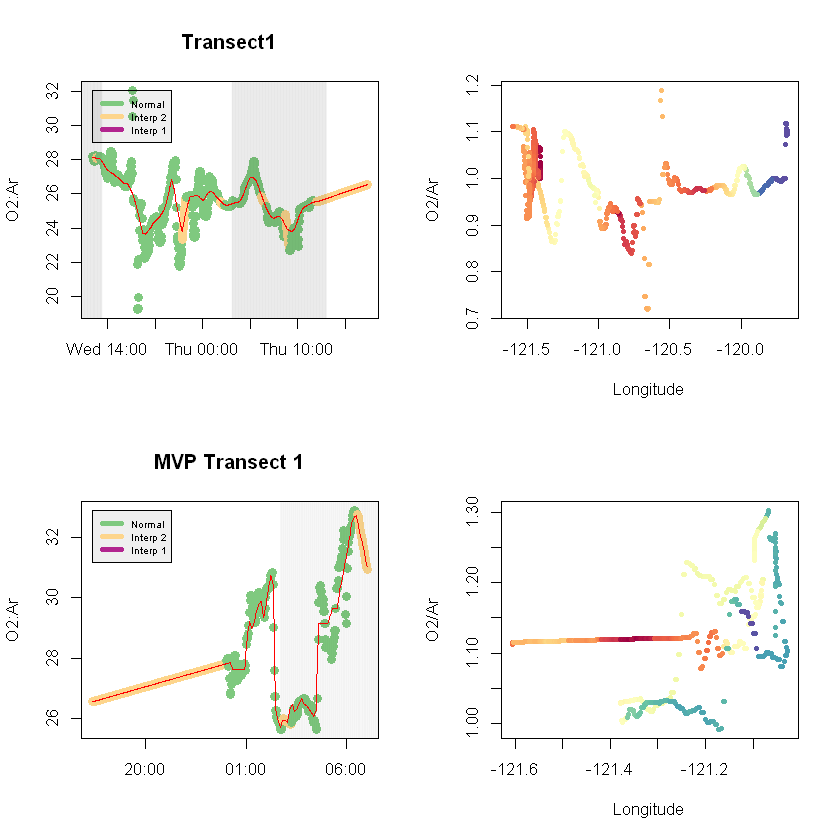

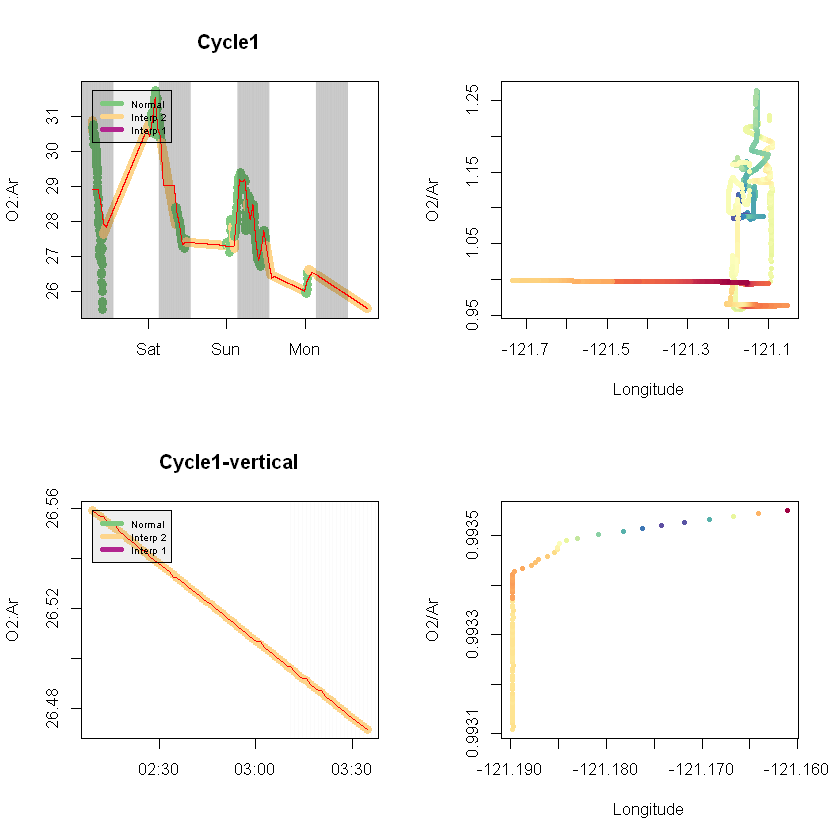

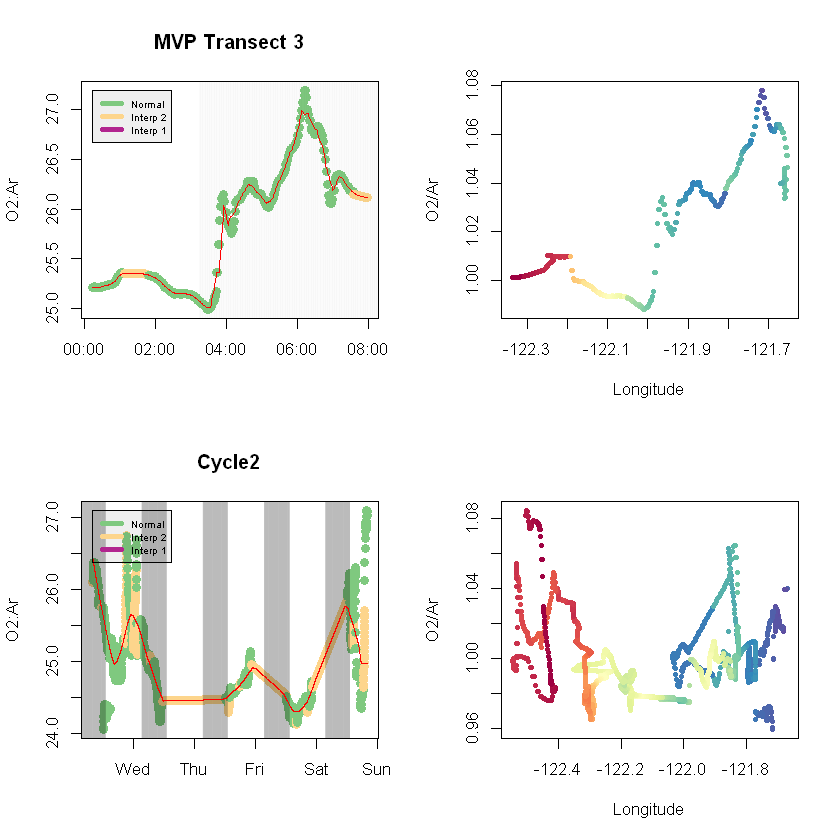

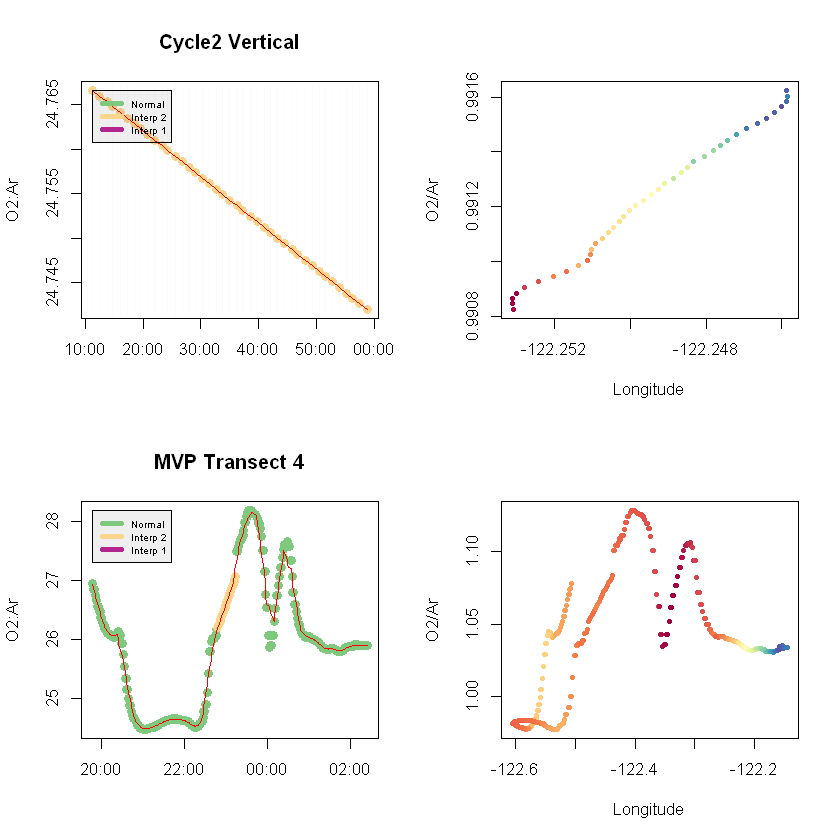

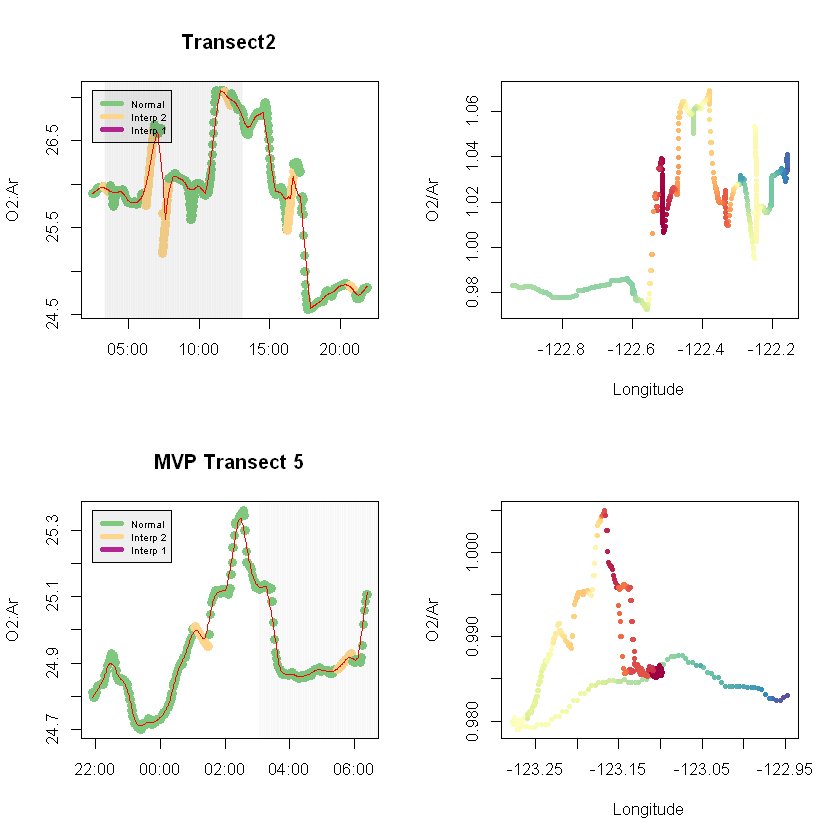

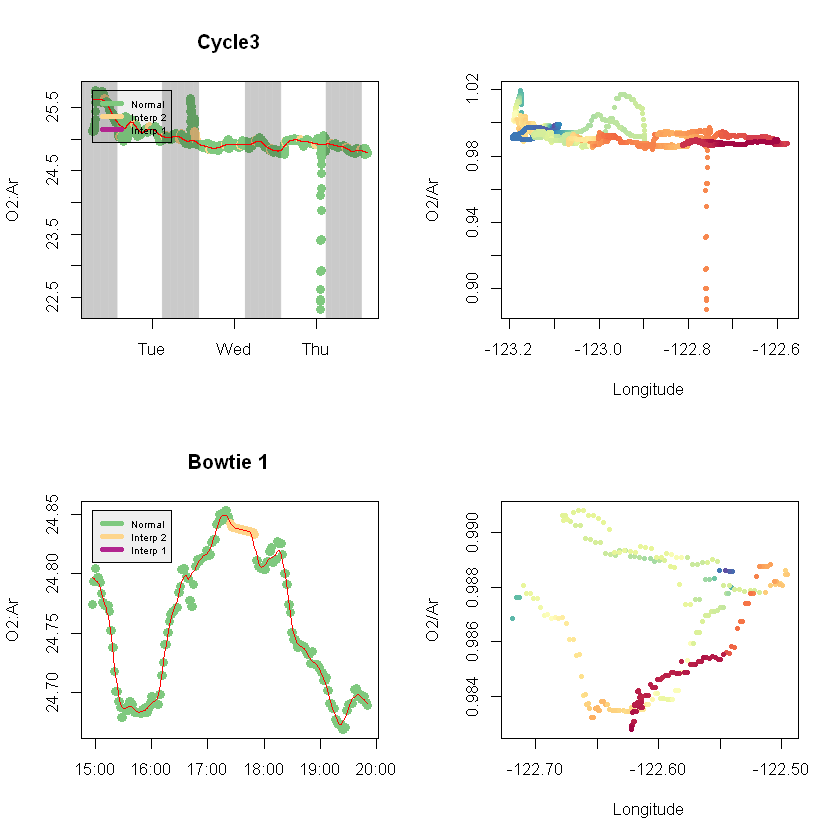

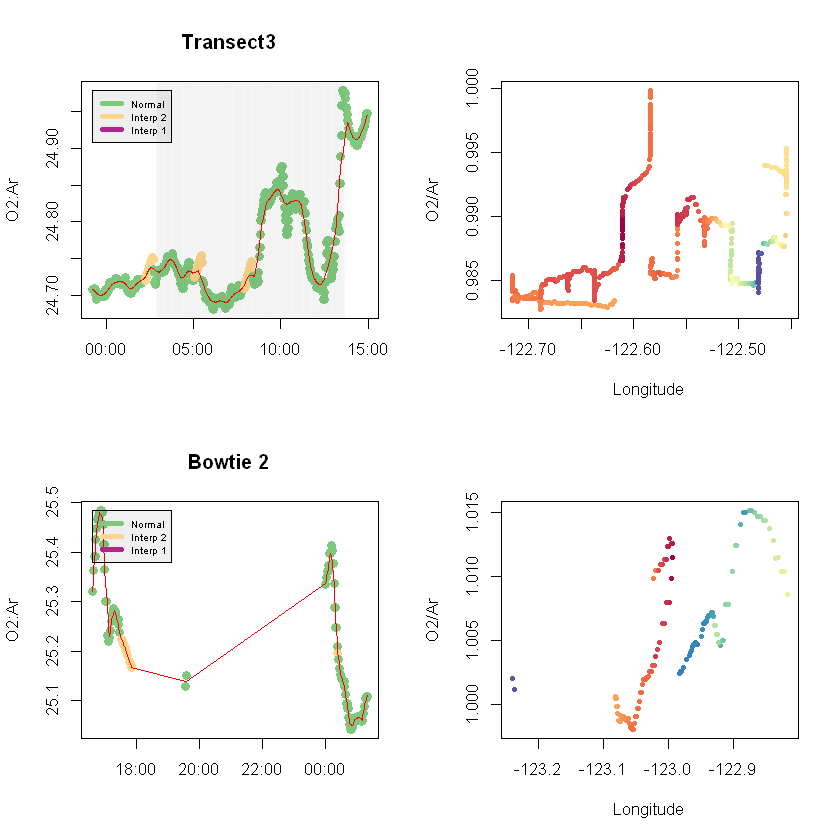

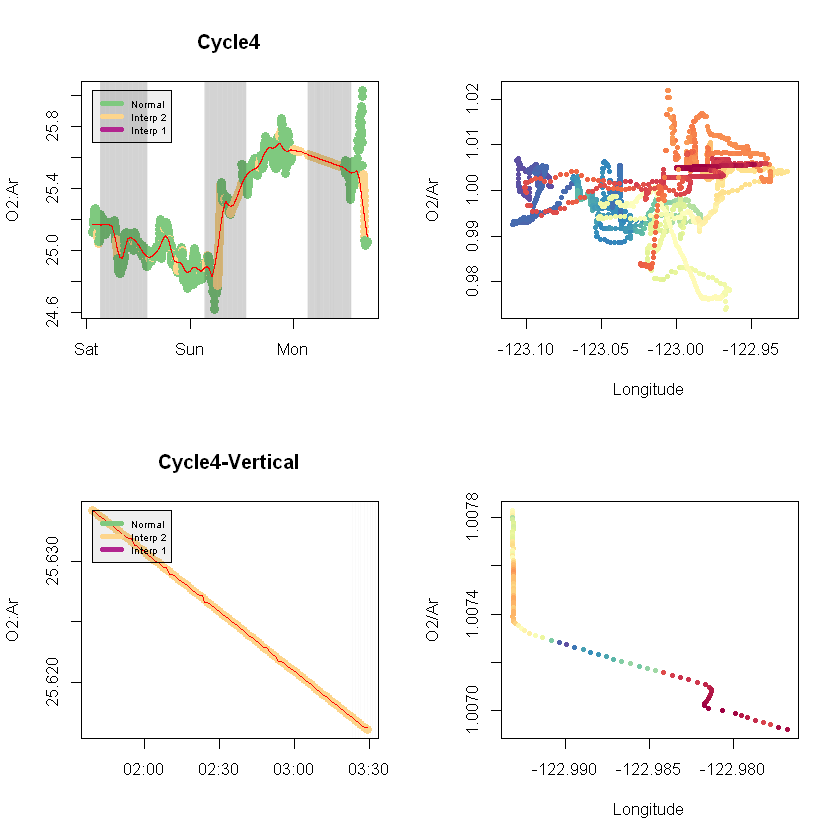

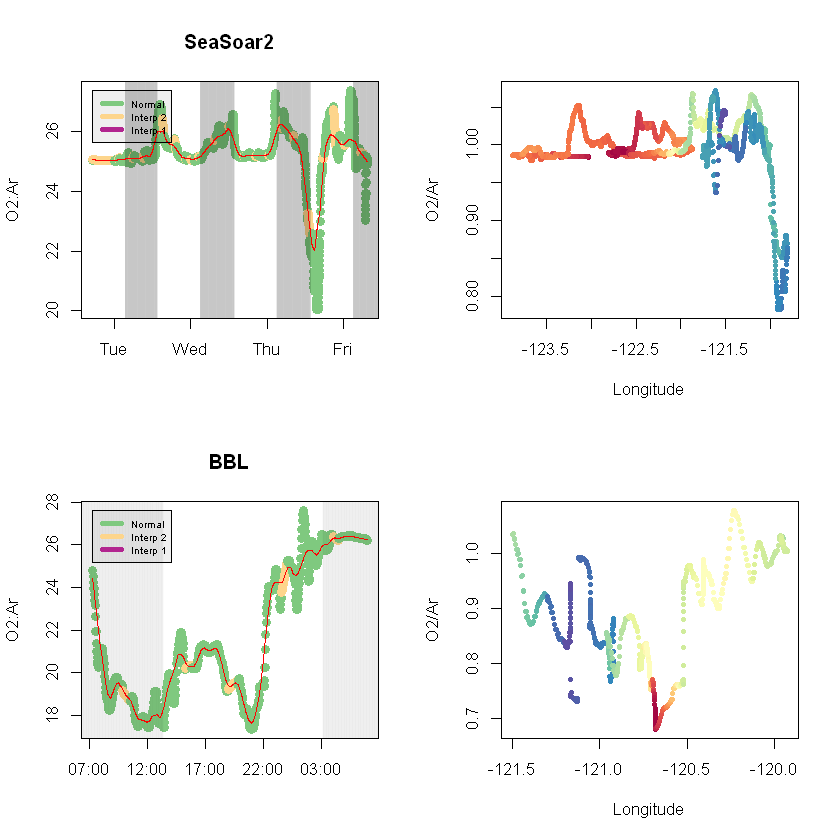

png 
  3

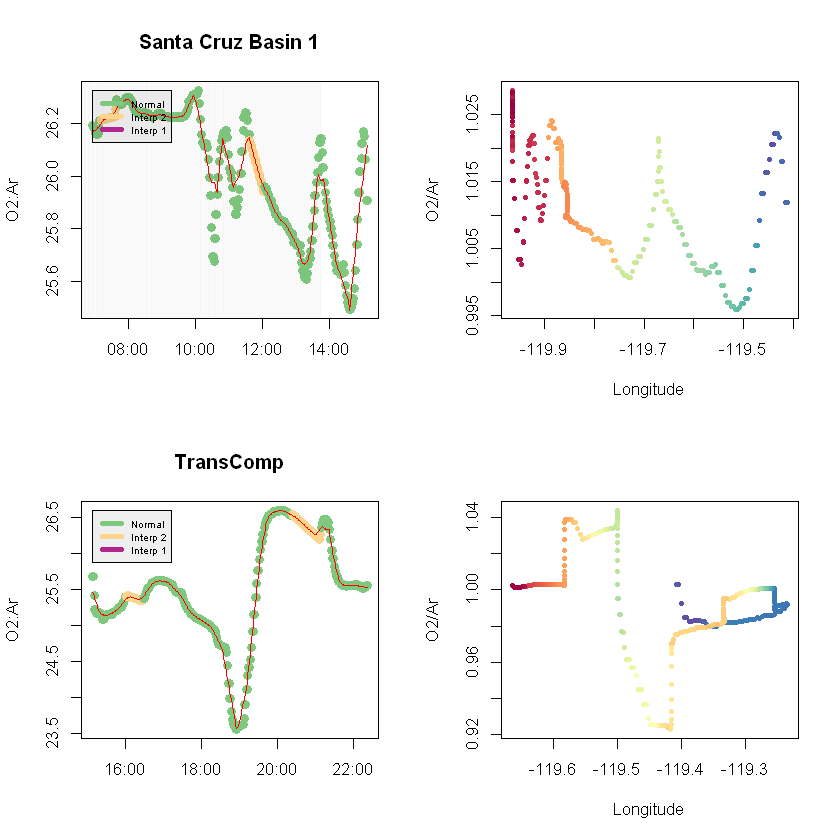

In [24]:
#pdf('Output/NCP Module - NCP Cycles Preliminary pt2.pdf')
#png('Output/NCP Module - NCP Cycles Preliminary pt2.png')

par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    #l = l[ship.data$NCP[l] > -10000 & ship.data$NCP[l] < 10000]
    
    ## Set colors
    col = make.div.pal(ship.data$k[l], 100)
    flag.col = get.qual.pal(4)
    
    ######################
    ## Plot Time series ##
    ######################
    plot(ship.data$DT[l], ship.data$EIMS.O2.Ar[l], main=i, pch=16, cex=1.2, lwd=2, ylab='O2:Ar', xlab='',
        col=flag.col[ship.data$EIMS.O2.Ar.FLAG[l]])
    add.daynight('#00000004')
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$EIMS.O2.Ar[l], f = 0.05)
    lines(mod, col='#ff0000', lwd=1)
    legend(ship.data$DT[l[1]], max(ship.data$EIMS.O2.Ar[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.6, lwd=4, bg='#00000010')
    
    ##################
    ## Spatial Plot ##
    ##################
    plot(ship.data$LO[l], ship.data$EIMS.O2.Ar[l]/ship.data$EIMS.O2.Ar.cal[l], pch=20, col=col, ylab='O2/Ar', xlab='Longitude')
    add.daynight('#00000004')
}

dev.off()

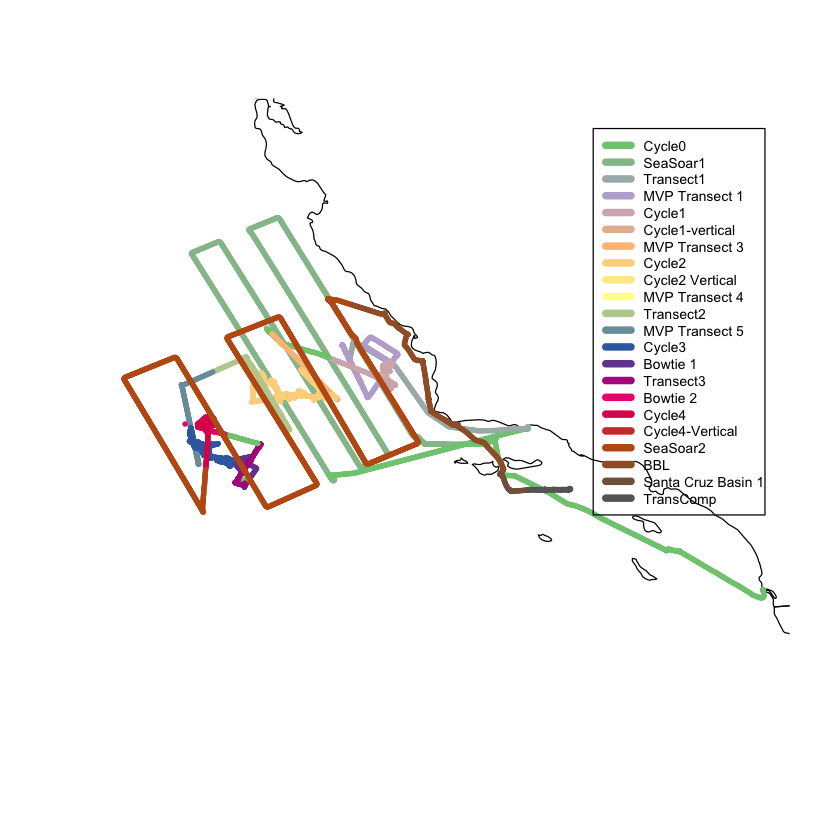

In [15]:
#png('Output/NCP Module - Cycle Map.png')

col = get.qual.pal(length(unique(ship.data$Cycle)))
cols = sapply(ship.data$Cycle, function(x) {which(unique(ship.data$Cycle) == x)})

plot.map(ship.data$LO, ship.data$LA, col=col[cols], pch=16, cex = 0.6)
legend(-119, 37.5, c(unique(ship.data$Cycle)), col=col[unique(cols)], lwd=6, cex=0.7)

#dev.off()

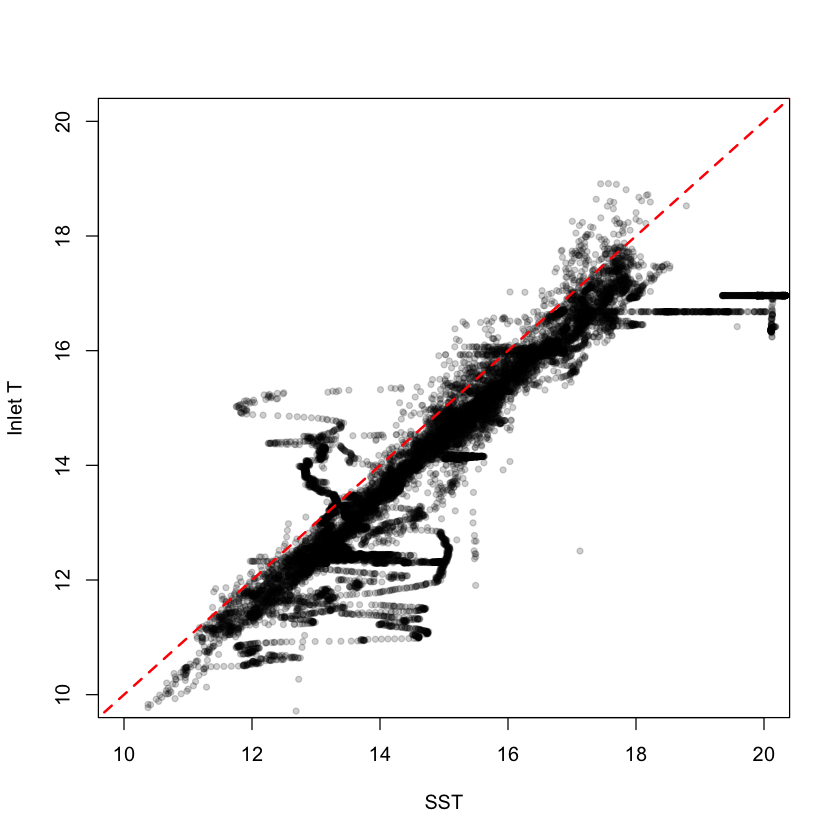

In [12]:
plot(ship.data$TT, ship.data$Inlet.T, pch=20, xlim=c(10,20), ylim=c(10,20), col='#00000030',
     ylab='Inlet T', xlab='SST')

lines(c(0,100), c(0, 100), col='red', lty=2, lwd=2)